In [1]:
#!L
import torch
print (torch.cuda.device_count())
print (torch.__version__)

1
1.6.0


In [2]:
%pip install scikit-image scikit-learn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 29.2 MB 13.3 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 38.0 MB/s eta 0:00:01
     |████████████████████████████████| 162 kB 37.8 MB/s 
     |████████████████████████████████| 4.4 MB 38.2 MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


### Using pre-trained model

Today we're going to build and fine-tune CNN based on weights pre-trained on ImageNet - one of the most popular classification datasets.
More about imagenet: http://image-net.org/
Setup: classify from a set of 1000 classes.

In [3]:
import requests
import os

# class labels
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
labels = {int(key):value for (key, value) in requests.get(LABELS_URL).json().items()}

/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'dict'> with size: 1000
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}


In [4]:
print(list(labels.items())[:5])

[(0, 'tench, Tinca tinca'), (1, 'goldfish, Carassius auratus'), (2, 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias'), (3, 'tiger shark, Galeocerdo cuvieri'), (4, 'hammerhead, hammerhead shark')]


/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'dict'> with size: 1000
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}


In [5]:
print(list(filter(lambda x: 'banana' in x[1], labels.items())))

[(954, 'banana')]


/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'dict'> with size: 1000
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}


### TorchVision
PyTorch has several companion libraries, one of them being [torchvision](https://github.com/pytorch/vision/tree/master/) - it contains a number of popular vision datasets, preprocessing tools and most importantly, [pre-trained models](https://github.com/pytorch/vision/tree/master/torchvision/models).

For now, we're going to use resnet-50 network.

![img](https://miro.medium.com/max/1000/1*YQgpwj-Wde7r8bFqXy2ruw.png?w=650&h=192)

Let's first look at the code here: [url](https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py)

In [6]:
#!L
from torchvision.models.resnet import resnet50

model = resnet50(pretrained=True,      # load existing weights
                    )

model.train(False)
model.cuda()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/jupyter/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'int'>
Walking trough too many objects
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}


In [8]:
#!L
import torch

dummy_x = torch.randn(5, 3, 224, 224).cuda()
model(dummy_x)

tensor([[-0.5684, -0.1496,  0.0460,  ..., -2.3272, -1.2086,  1.4417],
        [-0.6382,  0.2713,  0.2529,  ..., -2.4868, -1.2134,  1.4880],
        [-0.5605,  0.2179,  0.1422,  ..., -2.4647, -1.1811,  1.4533],
        [-0.4405,  0.0513,  0.0118,  ..., -2.4622, -0.9916,  1.2360],
        [-0.7140,  0.2054,  0.0236,  ..., -2.3348, -0.9289,  1.4440]],
       device='cuda:0', grad_fn=<AddmmBackward>)

/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'int'>
Walking trough too many objects
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}


### Predict class probabilities

In [9]:
# If using Colab
os.system('mkdir -p sample_images')
os.system('wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/sem4_spring19/week04_finetuning/sample_images/albatross.jpg -O sample_images/albatross.jpg')

0

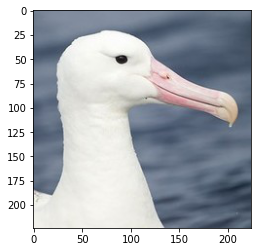

top-10 classes are: 
 [prob : class label]
0.9938 :	albatross
0.0023 :	spoonbill
0.0011 :	hammerhead
0.0006 :	American egret
0.0005 :	goose
0.0003 :	pelican
0.0003 :	oystercatcher
0.0002 :	ptarmigan
0.0001 :	crane


/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'int'>
Walking trough too many objects
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}
/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'dict'> with size: 1000
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}


In [10]:
#!L
import matplotlib.pyplot as plt
from skimage.transform import resize
%matplotlib inline

img = resize(plt.imread('sample_images/albatross.jpg'), (224, 224))
plt.imshow(img)
plt.show()


def transform_input(img):
    return torch.as_tensor(img.reshape([1, 224, 224, 3]).transpose([0, 3, 1, 2]), dtype=torch.float32)


def predict(img):
    img = transform_input(img).cuda()
    
    probs = torch.nn.functional.softmax(model(img), dim=-1).cpu()
    
    probs = probs.data.numpy()
    
    top_ix = probs.ravel().argsort()[-1:-10:-1]
    print ('top-10 classes are: \n [prob : class label]')
    for l in top_ix:
        print ('%.4f :\t%s' % (probs.ravel()[l], labels[l].split(',')[0]))
        

predict(img)

### Having fun with pre-trained nets

In [11]:
os.system("wget http://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg -O img.jpg")

0

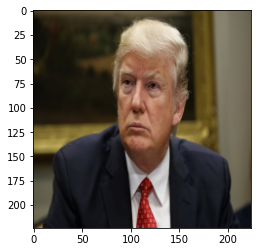

top-10 classes are: 
 [prob : class label]
0.4820 :	suit
0.4616 :	Windsor tie
0.0227 :	bolo tie
0.0054 :	lab coat
0.0054 :	groom
0.0031 :	bow tie
0.0017 :	hourglass
0.0016 :	trench coat
0.0009 :	stethoscope


/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'dict'> with size: 1000
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}
/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'int'>
Walking trough too many objects
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}


In [12]:
#!L
img = resize(plt.imread('img.jpg'), (224, 224))
plt.imshow(img)
plt.show()

predict(img)

Let's introduce a bit of our brand-new reality into the seminar!

In [13]:
os.system("wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/spring20/seminar04-finetuning/sample_images/plague-doctor-mask.jpg -O sample_images/mask.jpg")

0

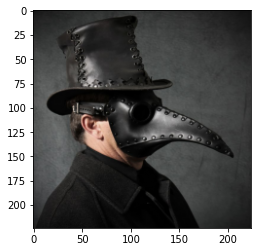

top-10 classes are: 
 [prob : class label]
0.0962 :	sunglass
0.0960 :	cowboy hat
0.0957 :	revolver
0.0640 :	sunglasses
0.0570 :	trench coat
0.0526 :	cornet
0.0482 :	gasmask
0.0232 :	hoopskirt
0.0229 :	mask


/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'dict'> with size: 1000
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}
/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'int'>
Walking trough too many objects
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}


In [14]:
#!L
img = resize(plt.imread('sample_images/mask.jpg'), (224, 224))
plt.imshow(img)
plt.show()

predict(img)

# Grand-quest: Dogs Vs Cats
* original competition
* https://www.kaggle.com/c/dogs-vs-cats
* 25k JPEG images of various size, 2 classes (guess what)

### Your main objective
* In this seminar your goal is to fine-tune a pre-trained model to distinguish between the two rivaling animals
* The first step is to just reuse some network layer as features

In [15]:
os.system("wget -nc https://www.dropbox.com/s/ae1lq6dsfanse76/dogs_vs_cats.train.zip?dl=1 -O data.zip")
os.system("unzip -n data.zip")

0

### How to get features
During good old days in Torch7 you could access any intermediate output from the sequential model. Nowadays it's a bit more difficult though it's not Tensorflow where you need to compile another model for that. Here we're going to redefine the last layer... yes, to do nothing.

In [17]:
#!L
from copy import deepcopy  # in case you still need original model

embedding = deepcopy(model)

class Identity(torch.nn.Module):

    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x
        
    
# redefine the last layer to be Identity
embedding.fc = Identity().cuda()

assert embedding(transform_input(img).cuda()).cpu().data.numpy().shape == (1, 2048), "your output for single image should have shape (1, 2048)"

/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'int'>
Walking trough too many objects
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}
/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'str'>
Walking trough too many objects
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}


# for starters
* Train sklearn model, evaluate validation accuracy (should be >80%

In [19]:
#!L

#extract features from images
from tqdm import tqdm
from skimage.io import imread
import skimage
import PIL.Image as Image
import os
import numpy as np

X = []
Y = []

batch_size = 32
imgs = np.zeros([batch_size, 224, 224, 3])
batch_index = 0

for fname in tqdm(os.listdir('train')):
    
    y = fname.startswith("cat")
    Y.append(y)
    
    img = skimage.img_as_ubyte(imread(os.path.join("train", fname)))
    
    img = np.array(Image.fromarray(img).resize((224, 224))) / 255.
    imgs[batch_index] = img
    
    if batch_index == batch_size - 1:
        input_tensor = torch.as_tensor(imgs.transpose([0,3,1,2]), dtype=torch.float32)
    
        # use your embedding model to produce feature vector
        features = embedding(input_tensor.cuda()).cpu().data.numpy()
        
        X.append(features)
        
        batch_index = 0
        continue
        
    batch_index += 1

100%|██████████| 25000/25000 [04:54<00:00, 84.79it/s]
/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'list'> with size: 25000
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}
/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'int'>
Walking trough too many objects
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}
/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'str'>
Walking trough too many objects
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}


In [20]:
#!L
X = np.concatenate(X) #stack all [1xfeatures] matrices into one. 
assert X.ndim == 2
#WARNING! the concatenate works for [1xN] matrices. If you have other format, stack them yourself.

#crop if we ended prematurely
Y = np.array(Y[:len(X)])

print(X.shape, Y.shape)

(24992, 2048) (24992,)


/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'int'>
Walking trough too many objects
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}
/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'str'>
Walking trough too many objects
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}


In [21]:
#<split data here or use cross-validation>
import sklearn.model_selection
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X, Y, test_size=2000)

In [22]:
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(22992, 2048) (2000, 2048) (22992,) (2000,)


__load our dakka__
![img](https://s-media-cache-ak0.pinimg.com/564x/80/a1/81/80a1817a928744a934a7d32e7c03b242.jpg)

In [23]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [24]:
cl = DecisionTreeClassifier()
cl.fit(X_train[:2000], y_train[:2000])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [26]:
print (np.mean(cl.predict_proba(X_val).argmax(axis=-1) == y_val))

0.94


In [27]:
cl = LogisticRegression()
cl.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [28]:
print (np.mean(cl.predict_proba(X_val).argmax(axis=-1) == y_val))

0.9845


# Main quest

* Get the score improved!
* You have to reach __at least 95%__ on the test set. More = better.

No methods are illegal: ensembling, data augmentation, NN hacks. 
Just don't let test data slip into training.


### Split the raw image data
  * please do train/validation/test instead of just train/test
  * reasonable but not optimal split is 20k/2.5k/2.5k or 15k/5k/5k

### Build a few layers on top of chosen "neck" layers.
  * a good idea is to just stack more layers inside the same network
  * alternative: stack on top of get_output

### Train the newly added layers for some iterations
  * you can selectively train some weights by sending the correct parameters in the optimizer
      * `opt = torch.optim.Adam([head_only.parameters()])``
  * it's cruicial to monitor the network performance at this and following steps

### Fine-tune the network body
  * probably a good idea to SAVE your new network weights now 'cuz it's easy to mess things up.
  * Moreover, saving weights periodically is a no-nonsense idea
  * even more cruicial to monitor validation performance
  * main network body may need a separate, much lower learning rate

In [39]:
#!L
from copy import deepcopy  # in case you still need original model

embedding = deepcopy(model)
 
# redefine the last layer to be Identity
embedding.fc = torch.nn.Linear(2048, 2).cuda()

assert embedding(transform_input(img).cuda()).cpu().data.numpy().shape == (1, 2), "your output for single image should have shape (1, 2048)"


/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'int'>
Walking trough too many objects
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}
/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'str'>
Walking trough too many objects
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}
/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'str'>
Walking trough too many objects
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}
/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'list'> with s

In [31]:
#!L
names = os.listdir('train')
import random
random.shuffle(names)
train_names = names[2000:]
val_names = names[:2000]

/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'int'>
Walking trough too many objects
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}
/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'list'> with size: 25000
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}
/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'list'> with size: 23000
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}
/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'list'> with size: 2000
Use %enable_full_w

In [32]:
#!L
def validate(model, names):
    batch_size = 1
    imgs = np.zeros([batch_size, 224, 224, 3])
    batch_index = 0
    n_correct = 0.0

    for fname in tqdm(names):
        y = fname.startswith("cat")
        
        img = skimage.img_as_ubyte(imread(os.path.join("train", fname)))

        img = np.array(Image.fromarray(img).resize((224, 224))) / 255.
        imgs[batch_index] = img

        input_tensor = torch.as_tensor(imgs.transpose([0,3,1,2]), dtype=torch.float32)

        # use your embedding model to produce feature vector
        features = model(input_tensor.cuda()).cpu().data.numpy()
        if features.ravel().argmax() == int(y):
            n_correct += 1
    return n_correct / len(names)
        

/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'int'>
Walking trough too many objects
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}
/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'list'> with size: 25000
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}
/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'list'> with size: 23000
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}
/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'list'> with size: 2000
Use %enable_full_w

In [41]:
#!L
print (validate(embedding, val_names))

100%|██████████| 2000/2000 [00:51<00:00, 38.78it/s]
/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'int'>
Walking trough too many objects
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}
/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'tuple'>
Walking trough too many objects
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}
/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'str'>
Walking trough too many objects
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}
/kernel/lib/python3.7/site-packages/ipystate/state.py:135: Us

0.984


In [40]:
#!L

Y = []

batch_size = 32
imgs = np.zeros([batch_size, 224, 224, 3])
batch_index = 0

opt = torch.optim.Adam(embedding.fc.parameters(), lr=0.0001/4)
loss = torch.nn.CrossEntropyLoss()

for fname in tqdm(train_names):
    y = fname.startswith("cat")
    Y.append(y)
    
    img = skimage.img_as_ubyte(imread(os.path.join("train", fname)))
    
    img = np.array(Image.fromarray(img).resize((224, 224))) / 255.
    imgs[batch_index] = img
    
    if batch_index == batch_size - 1:
        input_tensor = torch.as_tensor(imgs.transpose([0,3,1,2]), dtype=torch.float32)
        y = torch.as_tensor(np.array(Y), dtype=torch.long).cuda()
    
        # use your embedding model to produce feature vector
        embedding.zero_grad()
        features = embedding(input_tensor.cuda())
        l = loss(features, y)
        l.backward()
        opt.step()
        Y=[]
        batch_index = 0
        continue
        
    batch_index += 1

 12%|█▏        | 2792/23000 [00:43<05:13, 64.54it/s]
/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'int'>
Walking trough too many objects
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}
/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'tuple'>
Walking trough too many objects
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}
/kernel/lib/python3.7/site-packages/ipystate/state.py:135: UserWarning: Skipping walk through <class 'str'>
Walking trough too many objects
Use %enable_full_walk to serialize all variables correctly
  {name: self._state[name] for name in self._state.varnames() if not self._skip_variable(name)}
/kernel/lib/python3.7/site-packages/ipystate/state.py:135: U

KeyboardInterrupt: 

# Bonus: #deepdream

Probably it's better to use inception-v3 network here

https://twitter.com/search?q=%23deepdream&src=typd

Code is heavily based on https://github.com/thesemicolonguy/deep-dream-pytorch

Original blogpost where more ideas can be taken from: https://research.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html

In [ ]:
from PIL import Image, ImageFilter, ImageChops
from torchvision import transforms
import numpy as np

In [ ]:
modulelist = list(model.children())
print(len(modulelist))

In [ ]:
#!L
preprocess = transforms.Compose([
#    transforms.Resize((224, 224)),  # do we really need this now?
    transforms.ToTensor()#,
    ])


def dd_helper(image, layer, iterations, lr):
    input_var = torch.tensor(preprocess(image).unsqueeze(0), requires_grad=True, device='cuda:0', 
                             dtype=torch.float32)
    model.zero_grad()
    for i in range(iterations):
        out = input_var
        for j in range(layer):
            out = modulelist[j](out)
        loss = out.norm()
        loss.backward()
        input_var.data = input_var.data + lr * input_var.grad.data
    
    input_im = input_var.data.squeeze(0).cpu()
    input_im.transpose_(0, 1)
    input_im.transpose_(1, 2)
    input_im = np.clip(input_im, 0, 1)
    im = Image.fromarray(np.uint8(input_im * 255))
    return im

In [ ]:
def deep_dream(image, layer, iterations, lr, octave_scale, num_octaves):
    if num_octaves>0:
        image1 = image.filter(ImageFilter.GaussianBlur(2))
        if (image1.size[0] / octave_scale < 1 or image1.size[1] / octave_scale < 1):
            size = image1.size
        else:
            size = (int(image1.size[0] / octave_scale), int(image1.size[1] / octave_scale))
            
        image1 = image1.resize(size, Image.ANTIALIAS)
        image1 = deep_dream(image1, layer, iterations, lr, octave_scale, num_octaves-1)
        size = (image.size[0], image.size[1])
        image1 = image1.resize(size, Image.ANTIALIAS)
        image = ImageChops.blend(image, image1, 0.6)
    print("-------------- Recursive level: ", num_octaves, '--------------')
    img_result = dd_helper(image, layer, iterations, lr)
    img_result = img_result.resize(image.size)
    plt.imshow(img_result)
    return img_result

In [ ]:
img = Image.fromarray(plt.imread('img.jpg'))
img

In [ ]:
output = deep_dream(img, 5, 5, 0.3, 2, 20)

In [ ]:
output = deep_dream(img, 12, 5, 0.2, 2, 1)

In [ ]:
#can you implement one class probability optimization to make model dream about bananas
<YOUR CODE>

# Bonus 2: Adversarial Attack

Original PyTorch tutorial is [here](https://pytorch.org/tutorials/beginner/fgsm_tutorial.html)

In [ ]:
# Change the Deep Dream step function
# to make it doing adversarial example from original image


def dd_helper_modified(image, layer, iterations, lr):
    input_var = torch.tensor(preprocess(image).unsqueeze(0), requires_grad=True, device='cuda:0',
                             dtype=torch.float32)
    model.zero_grad()
    for i in range(iterations):
        out = input_var
        for j in range(layer):  # maybe change this
            out = modulelist[j](out)
        loss = out.norm()
        loss.backward()
        input_var.data = input_var.data + lr * input_var.grad.data # and probably this
    input_im = input_var.data.squeeze(0).cpu()
    input_im.transpose_(0, 1)
    input_im.transpose_(1, 2)
    input_im = np.clip(input_im, 0, 1)
    im = Image.fromarray(np.uint8(input_im * 255))
    return im

In [ ]:
img = Image.fromarray(plt.imread('img.jpg'))
img_adv = dd_helper(img, ?, ?, ?)   # YOUR CODE
img_adv

In [ ]:
predict(resize(np.asarray(img_adv), (224, 224)))